In [78]:
import pandas as pd, glob, os, matplotlib.pyplot as plt, numpy as np
from datetime import datetime

In [79]:
main_time_step_global = 10

In [80]:
############################# LOADING #############################

In [81]:
fname_trade = 'trade_2017-06-19_11-16.csv'
#Flag = 1: buy, Flag = 2: sell, Flag = 4: unknown 
df_trade = pd.read_csv(fname_trade, sep=";", header = None, names = ['Market', 'From', 'To', 
                                                               'Flag', 'TradeId', 'Timestamp',
                                                               'Quantity', 'Price', 'Total'])

In [82]:
fname_current = 'current_2017-06-19_11-16.csv'
#Flag = 1: price up, Flag = 2: price down, Flag = 4: price unchanged
df_current = pd.read_csv(fname_current, sep=";", header = None, names = ['Market', 'From', 'To',
                                                                'Flag', 'Price', 'Timestamp',
                                                                'LastVolume', 'LastVolumeTo',
                                                                'LastTradeId', 'Volume24h',
                                                                'Volume24hTo'])

In [83]:
############################# TIME SYNC #############################

In [84]:
timestamp_start_global = max(df_trade['Timestamp'].iloc[0], df_current['Timestamp'].iloc[0])
timestamp_end_global = min(df_trade['Timestamp'].iloc[-1], df_current['Timestamp'].iloc[-1])

tmp = timestamp_start_global
while tmp % 10 != 0:
    tmp += 1
timestamp_start_global = tmp
timestamp_end_global += tmp - timestamp_start_global

duration_global = list(range(int(timestamp_start_global) - main_time_step_global,
                             int(timestamp_end_global), main_time_step_global))

print(timestamp_start_global, 'TO', timestamp_end_global)
print('DIFF:', timestamp_end_global - timestamp_start_global)

1497863800.0 TO 1497879895.0
DIFF: 16095.0


In [85]:
############################# OTHER SHITS #############################

In [86]:
df_trade.Flag = df_trade.Flag.where(df_trade.Flag != 2, -1) # for easy multiply with Total and sum same Timestamp

In [99]:
df_trade_repaired = pd.DataFrame({'Timestamp': duration_global, 'BuySell': 0})
df_current_repaired = pd.DataFrame({'Timestamp': duration_global, 'Price': 0})

for tt in duration_global:
    tmp = df_trade[(abs(tt - df_trade.Timestamp) <= main_time_step_global) & (df_trade.Timestamp > tt)]
    df_trade_repaired.BuySell[df_trade_repaired.Timestamp == tt] = np.sum(np.multiply(tmp.Total, tmp.Flag))
    
    tmp = df_current[(abs(tt - df_current.Timestamp) <= main_time_step_global) & (df_current.Timestamp > tt)]
    df_current_repaired.Price[df_current_repaired.Timestamp == tt] = np.mean(tmp.Price)

In [100]:
#plt.figure(figsize=(15, 8), dpi = 80)
##plt.plot(df_trade_repaired.Timestamp, df_trade_repaired.BuySell)
#plt.bar(range(df_trade_repaired.BuySell.size), df_trade_repaired.BuySell, width=10)
#plt.show()

In [101]:
############################# CURRENT #############################

In [102]:
df_current_repaired.Price = df_current_repaired.Price.interpolate()

In [103]:
df_current_trade_repaired = pd.merge(df_current_repaired, df_trade_repaired, how='left', on='Timestamp')

In [118]:
df_current_trade_repaired = df_current_trade_repaired[['Timestamp', 'BuySell', 'Price']]
df_current_trade_repaired.to_csv('merged_repaired_step_' + 
                                 str(main_time_step_global) + '_'
                                 '_'.join(fname_trade.split('_')[1:3]), header=None, index=None, sep=';')

In [108]:
df_current_trade_repaired[:5]

,Timestamp,BuySell,Price
0,1497863790,-0.823350,357.2000
1,1497863800,-6.108120,357.2000
2,1497863810,204.913609,356.9850
3,1497863820,0.000000,357.0925
4,1497863830,-1.786000,357.2000


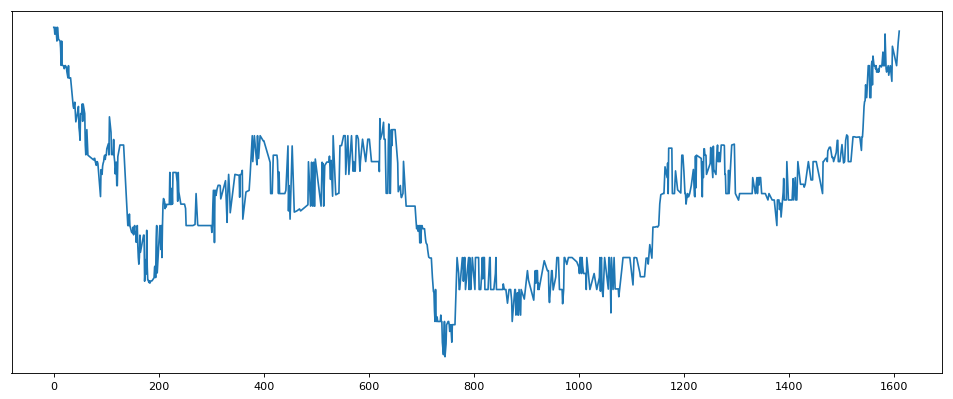

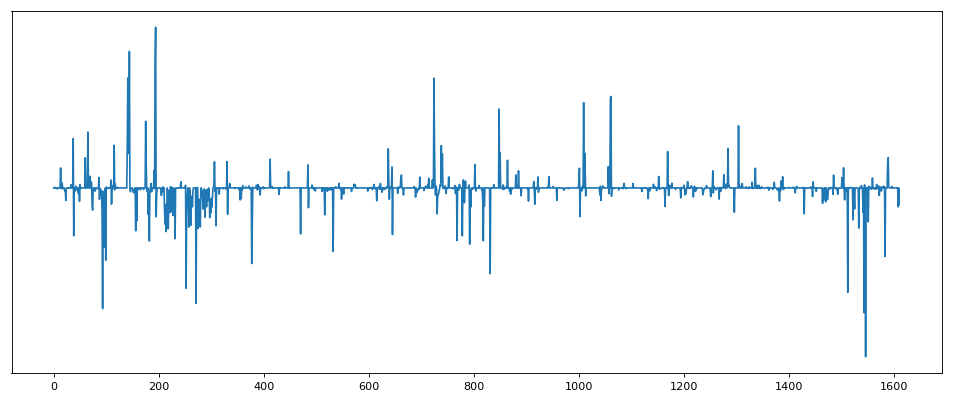

In [139]:
plt.figure(figsize=(15, 6), dpi = 80)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
plt.plot(df_current_trade_repaired.Price)

plt.figure(figsize=(15, 6), dpi = 80)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
plt.plot(df_current_trade_repaired.BuySell)
plt.show()

In [116]:
'_'.join(fname_trade.split('_')[1:3])

'2017-06-19_11-16.csv'